# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder


from utils import eda_train_path

# Load datasets

In [2]:
train_df = pd.read_csv(eda_train_path)

## Group by rate

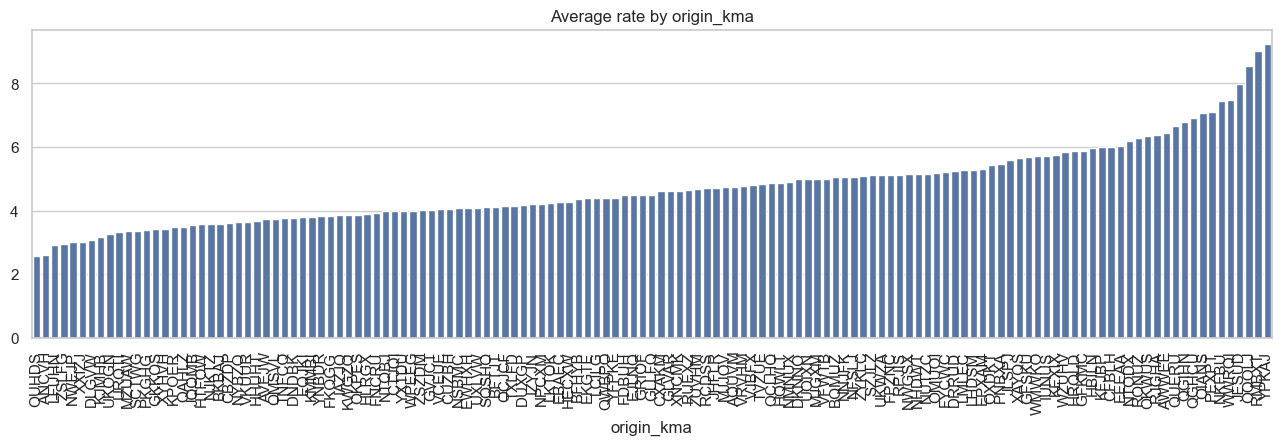

In [3]:
origin_means = train_df.groupby("origin_kma")["rate"].mean().sort_values()
destination_means = train_df.groupby("destination_kma")["rate"].mean().sort_values()

plt.figure(figsize=(16, 4))
sns.barplot(x=origin_means.index, y=origin_means.values)
plt.xticks(rotation=90)
plt.title("Average rate by origin_kma")
plt.show()

- Если количество KMA маленькое (< 50), можно использовать One-Hot Encoding.
- Если больше 100, лучше Target Encoding или Embeddings.
- Лучший метод кодирования → Target Encoding (mean rate по KMA).
- Если KMA очень много (500+), можно попробовать Embeddings.
- 135 уникальных origin_kma и 135 destination_kma → это среднее количество категорий.
- Существенные различия в среднем rate между разными origin_kma → KMA влияет на rate.
- График распределения rate по origin_kma неравномерный → у некоторых KMA средний rate в 2-3 раза выше, чем у других.
- Target Encoding, так как KMA влияет на rate, но их 135 → слишком много для One-Hot.
- Target Encoding (Mean Encoding) — это способ кодирования категориальных признаков, при котором каждая категория заменяется средним значением целевой переменной (rate) внутри этой категории.

- Добавляем два новых признака:
- origin_kma_mean_rate → средний rate по origin_kma.
- destination_kma_mean_rate → средний rate по destination_kma.


| Метод | Когда использовать? | Плюсы| Минусы |
|---|---|---|---|
| **One-Hot Encoding**| Если < 50 категорий | Простая интерпретация, не даёт искажений | Увеличивает размерность данных |
| **Target Encoding (Mean Encoding)** | Если > 50 категорий, но есть сильная связь с `rate` | Компактно, учитывает средний `rate`| Может приводить к ликажу (если считать по train) |
| **Embeddings**| Если > 200 категорий| Можно учитывать нелинейные зависимости | Требует сложных моделей|


| Метод | Описание| Плюсы| Минусы|
| --- | --- | --- | --- |
| **One-Hot Encoding (OHE)**| Создаёт отдельную колонку для каждого `KMA` (0/1) | Простая интерпретация<br>Хорошо работает для небольшого числа категорий| Не масштабируется (135 категорий = 135 новых колонок)<br>Не учитывает порядок категорий |
| **Target Encoding (Mean Encoding)** | Каждое `KMA` заменяется средним `rate` по этой категории| Учитывает влияние `KMA` на `rate`<br>Сохраняет информацию, не увеличивая размерность | Возможен leakage (если не обработать правильно) |
| **Frequency Encoding**| Каждое `KMA` заменяется частотой его встречаемости| Компактное представление<br>Работает в деревьях решений| Не учитывает зависимость с `rate` |
| **Leave-One-Out Encoding (LOO Encoding)** | Как Target Encoding, но исключает текущий объект из расчёта | Уменьшает leakage<br>Лучше для небольших выборок | Всё ещё возможен leakage|
| **Embedding Encoding**| Представляет `KMA` в виде векторного пространства | Учитывает сложные зависимости<br>Хорошо работает в DL| Требует сложной модели<br>Не подходит для классического ML|

# Target Encoding

## Compute mean rate per origin_kma and destination_kma (на train)

In [4]:
origin_kma_map = train_df.groupby("origin_kma")["rate"].mean().to_dict()
destination_kma_map = train_df.groupby("destination_kma")["rate"].mean().to_dict()

## Global mean rate для неизвестных KMA

In [5]:
global_mean_rate = train_df["rate"].mean()

## Функция для Target Encoding с обработкой unseen KMA

In [6]:
def apply_target_encoding(df, origin_map, destination_map, global_mean):
    df["origin_kma_mean_rate"] = df["origin_kma"].map(origin_map).fillna(global_mean)
    df["destination_kma_mean_rate"] = df["destination_kma"].map(destination_map).fillna(global_mean)
    return df

# Target Encoding к train, validation и test

In [7]:
train_df = apply_target_encoding(train_df, origin_kma_map, destination_kma_map, global_mean_rate)

In [8]:
train_df

,rate,valid_miles,transport_type,weight,pickup_date,origin_kma,destination_kma,origin_kma_mean_rate,destination_kma_mean_rate
0,4.7203,521.8451,MKPFX,9231.75,2019-11-10 10:42:00,OMUOI,LFUHN,5.169683,4.771916
1,4.9005,532.6675,MKPFX,11754.95,2019-11-10 10:42:00,OMUOI,LFUHN,5.169683,4.771916
2,4.7018,523.9188,MKPFX,9603.20,2019-11-10 10:42:00,OMUOI,LFUHN,5.169683,4.771916
3,4.6388,562.8296,MKPFX,8789.05,2019-11-10 10:42:00,OMUOI,LFUHN,5.169683,4.771916
4,5.0206,519.8782,MKPFX,9597.50,2019-11-10 10:42:00,OMUOI,LFUHN,5.169683,4.771916
...,...,...,...,...,...,...,...,...,...
286262,4.0141,283.5654,MKPFX,41394.00,2022-09-05 20:02:00,NUTZC,AWWEE,5.165258,4.810126
286263,5.4880,162.1160,MKPFX,15220.55,2022-09-05 20:02:00,FPZNC,NTODX,5.124705,5.192457
286264,5.3078,645.8933,KFEGT,41280.00,2022-09-05 20:12:00,RCDSS,EJLNQ,4.698443,5.660267
286265,5.2722,432.8540,MKPFX,11450.00,2022-09-05 20:42:00,OKPES,NTODX,3.868270,5.192457


# Save current version of `train_df`, `validation` and `test`

In [9]:
train_df.to_csv(eda_train_path, index=False)